In [1]:
import os
num_threads = "4"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy as sp
import sys
sys.path.append("../../src")
import importlib
import matplotlib.pyplot as plt
from sklearn import linear_model
import dcor
import torchsde
import pandas as pd
from torchdiffeq import odeint
import sklearn as sk
from sklearn import preprocessing
torch.set_default_dtype(torch.float32)

# Xs_t = torch.tensor(np.load("../../tools/SB-Iterative-Reference-Refinement/Notebooks/data/repres_data.npy", allow_pickle = True), dtype = torch.float32)
# scaler_op = sk.preprocessing.StandardScaler()
# data = {'x' : torch.tensor(scaler_op.fit_transform(Xs_t.reshape(-1, Xs_t.shape[-1])), dtype = torch.float32), 't_idx' : torch.tensor(np.repeat(np.arange(Xs_t.shape[0]), Xs_t.shape[1]))}

# _X = pd.read_csv("../data/dyn-CY/dyn-CY-1000-1/ExpressionData.csv", index_col=0).values.T
# _X = np.log1p(_X)
# scaler_op = sk.preprocessing.StandardScaler()
# pca_op = sk.decomposition.PCA()
# _t = pd.read_csv("../data/dyn-CY/dyn-CY-1000-1/PseudoTime.csv", index_col=0)
# T = 8
# bins = np.linspace(0, 1, T+1)[:-1]
# data = {'x': torch.tensor(scaler_op.fit_transform(pca_op.fit_transform(_X)), dtype = torch.float32), 't_idx' : torch.tensor(np.digitize(_t.values.flatten(), bins))-1}

# _X = torch.tensor(pd.read_csv("../data/mESC/X.csv", sep = '\t', index_col = 0).T.values, dtype = torch.float32)
# scaler_op = sk.preprocessing.StandardScaler()
# pca_op = sk.decomposition.PCA()
# _df_t = pd.read_csv("../data/mESC/time.txt", sep = '\t', header = None)
# _t = torch.tensor([{j : i for (i, j) in enumerate(_df_t.iloc[:, 0].unique())}[x] for x in _df_t.iloc[:, 0]])
# data = {'x' : torch.tensor(scaler_op.fit_transform(pca_op.fit_transform(_X))[:, range(10)], dtype = torch.float32), 't_idx' : _t}

torch.manual_seed(42)
np.random.seed(42)

# Simulate represillator data
import torchsde
class Repressilator(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    beta = 10
    n = 3
    k = 1
    gamma = 1
    sigma = 0.1
    def __init__(self):
        super().__init__()
    def f(self, t, x):
        x1, x2, x3 = x[:, 0], x[:, 1], x[:, 2]
        dx1 = self.beta / (1 + (x3 / self.k)**self.n) - self.gamma*x1
        dx2 = self.beta / (1 + (x1 / self.k)**self.n) - self.gamma*x2
        dx3 = self.beta / (1 + (x2 / self.k)**self.n) - self.gamma*x3
        return torch.vstack([dx1, dx2, dx3]).T
    # Diffusion
    def g(self, t, x):
        return torch.ones_like(x)*self.sigma
N = 1000
T = 10
x0 = torch.hstack([torch.randn(N, 2)*0.1+1, torch.randn(N, 1)*0.1+2])
ts = torch.linspace(0, T-1, 10)
x = torchsde.sdeint(Repressilator(), x0, ts, dt = 0.05)

N_obs = 100
Xs_t = torch.cat([x[i, torch.randperm(N)[:2*N_obs], :].unsqueeze(0) for i in range(T)])
Xs_t, Xs_t_val = Xs_t[:, :N_obs, :], Xs_t[:, N_obs:, :]

scaler_op = sk.preprocessing.StandardScaler(with_mean=True, with_std=False)
scaler_op.fit(Xs_t.reshape(-1, Xs_t.shape[-1]))
data = {'x' : torch.tensor(scaler_op.transform(Xs_t.reshape(-1, Xs_t.shape[-1])), dtype = torch.float32),
        't_idx' : torch.tensor(np.repeat(np.arange(Xs_t.shape[0]), Xs_t.shape[1])), 
        'x_val' : torch.tensor(scaler_op.transform(Xs_t_val.reshape(-1, Xs_t_val.shape[-1])), dtype = torch.float32),
        't_idx_val' : torch.tensor(np.repeat(np.arange(Xs_t_val.shape[0]), Xs_t_val.shape[1])), 
        'sigma' : Repressilator.sigma
       }
torch.save(data, "data.pkl")

In [3]:
import scipy as sp
# Get ground truth Jacobian
_x = sp.optimize.root(lambda x: Repressilator.beta / (1 + (x/Repressilator.k)**Repressilator.n) - Repressilator.gamma*x, 1.).x[0]
x_fixed = torch.full((1, 3), _x)
J = torch.func.jacrev(lambda x: Repressilator().f(_, x))(x_fixed).detach().squeeze()
D = torch.diag(torch.tensor(scaler_op.scale_)).float() if scaler_op.scale_ is not None else torch.eye(3)
J_scaled = D @ J @ torch.linalg.pinv(D)

torch.save({'x' : torch.tensor(scaler_op.transform(x_fixed)).flatten().float(), 'J' : J_scaled}, "gt_ref.pkl")

/home/stephenz/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [4]:
ts_traj_dense = torch.linspace(0, T-1, 100)
x_traj_dense = torchsde.sdeint(Repressilator(), x0, ts_traj_dense, dt = 0.05)
x_traj = torchsde.sdeint(Repressilator(), x0, ts, dt = 0.05)
torch.save({'x_traj' : x_traj, 'ts_traj' : ts, 
            'x_traj_dense' : x_traj_dense, 'ts_traj_dense' : ts_traj_dense}, "data_traj.pkl")

/data/gpfs/projects/punim0638/stephenz/envs/lfm/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/data/gpfs/projects/punim0638/stephenz/envs/lfm/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  retu

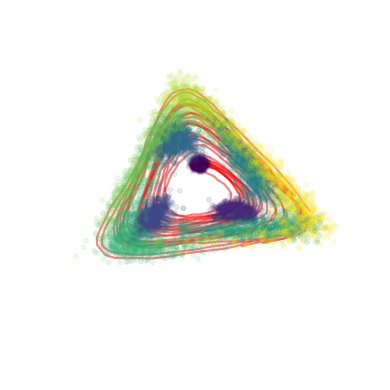

In [5]:
ax = plt.figure(figsize = (4, 4)).add_subplot(projection='3d')
ax.view_init(elev=30, azim=45, roll=0)
ax.scatter(x[..., 0], x[..., 1], x[..., 2], c = ts.repeat_interleave(N), alpha = 0.1, s = 10, rasterized = True);
for i in range(10):
    ax.plot(x_traj_dense[:, i, 0], x_traj_dense[:, i, 1], x_traj_dense[:, i, 2], c = 'red', alpha = 0.5)
plt.axis('off')
plt.tight_layout()
plt.savefig("../../figures/repressilator_3dplot_traj.pdf", dpi = 300)

In [6]:
d = data['x'].shape[-1]
T = len(np.unique(data['t_idx']))
ts = torch.linspace(0, T-1, T)

In [7]:
import fm
from tqdm import tqdm
import copy
suffix, it = "leaveout_-1_seed_1", 4
s_model = fm.MLP(d = d, hidden_sizes = [64, 64, 64], time_varying=True, activation = torch.nn.ReLU)
v_model = fm.MLP(d = d, hidden_sizes = [64, 64, 64], time_varying=True, activation = torch.nn.ReLU)
s_model.load_state_dict(torch.load(f"weights/otfm_score_iter_{it}_{suffix}.pt"))
v_model.load_state_dict(torch.load(f"weights/otfm_flow_iter_{it}_{suffix}.pt"))

ref_params = torch.load(f"weights/reference_iter_{it}_{suffix}.pt")

otfm = fm.LinearEntropicOTFM(data['x'], 
                      data['t_idx'], 
                      ts = ts,
                      sigma = data["sigma"],
                      A = ref_params["A"],
                      mu = ref_params["mu"],
                      T = T,
                      dim = d,
                      device = torch.device('cpu')
                  )


/home/stephenz/.local/lib/python3.9/site-packages/ot/bregman/_sinkhorn.py:1145: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


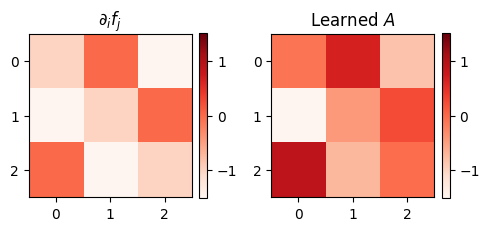

In [8]:
plt.figure(figsize = (5, 2.5))
plt.subplot(1, 2, 1)
im=plt.imshow(J.squeeze(), cmap = "Reds", vmin = -1.5, vmax = 1.5)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("$\\partial_i f_j$")
plt.subplot(1, 2, 2)
plt.title("Learned $A$")
im=plt.imshow(ref_params['A'], cmap = "Reds", vmin = -1.5, vmax = 1.5)
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig("../../figures/repressilator_jac_vs_A.pdf")

In [9]:
class OrnsteinUhlenbeck(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    def __init__(self, A, sigma):
        super().__init__()
        self.A = A
        self.sigma = sigma
    def f(self, t, x):
        return x @ self.A.T
    # Diffusion
    def g(self, t, x):
        return torch.ones_like(x)*self.sigma

In [10]:
# Try Gaussian approximation
Xs = [data['x'][data['t_idx'] == i] for i in range(T)]
means = [torch.mean(x, 0) for x in Xs]
covs = [torch.cov(x.T) for x in Xs]

In [11]:
from scipy.stats import multivariate_normal
import matplotlib.cm

def get_cmap(solid_color):
    cdict = {
        'red':   [(0.0, 1.0, 1.0),  # Start at white (1.0, 1.0, 1.0)
                  (1.0, solid_color[0], solid_color[0])],  # End at solid color

        'green': [(0.0, 1.0, 1.0),
                  (1.0, solid_color[1], solid_color[1])],

        'blue':  [(0.0, 1.0, 1.0),
                  (1.0, solid_color[2], solid_color[2])]
    }
    return matplotlib.colors.LinearSegmentedColormap('WhiteToBlue', cdict)

x = np.linspace(-1.75, 2.5, 100)
y = np.linspace(-1.75, 2.5, 100)
X, Y = np.meshgrid(x, y)
_X = np.vstack([X.reshape(-1), Y.reshape(-1)])
pos = np.dstack((X, Y))

def plot_bivariate(mean, cov, cm):
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z, levels=5, cmap=cm)
    
def plot_bivariate_3d(mean, cov, cm):
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z, levels=5, cmap=cm)

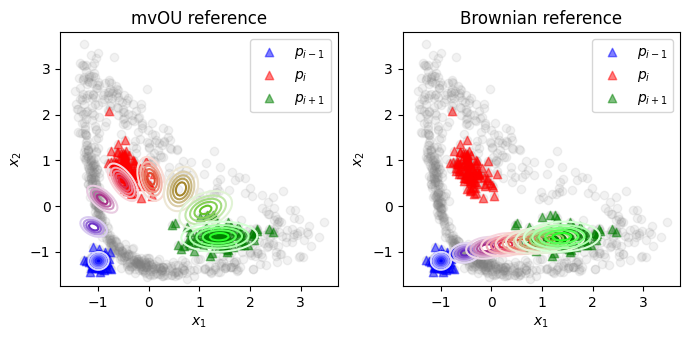

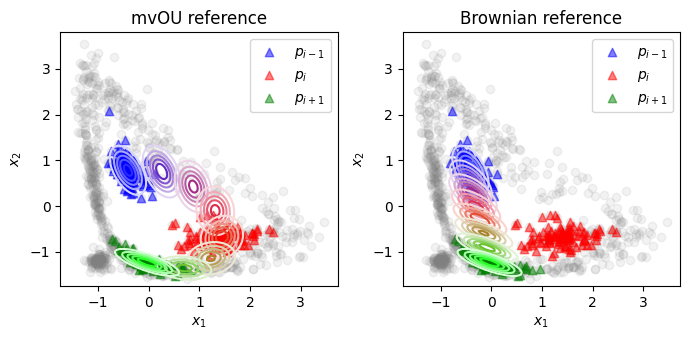

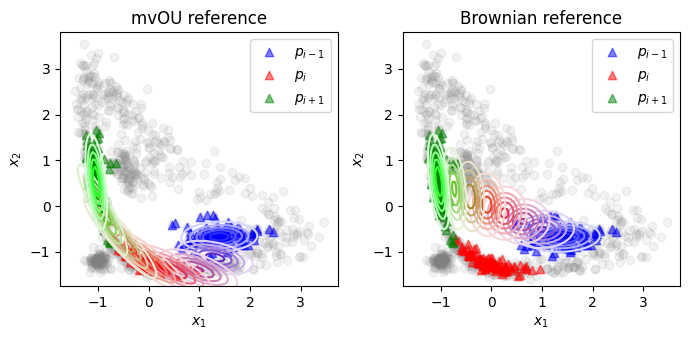

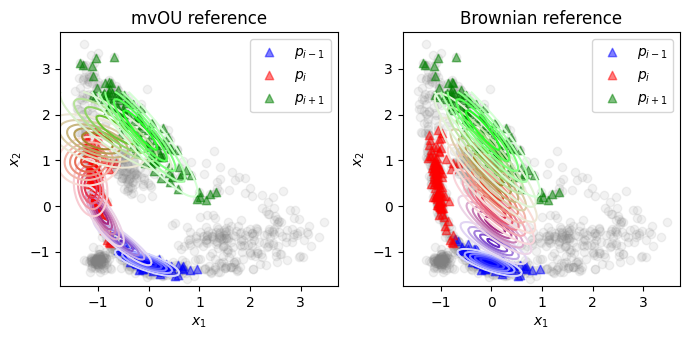

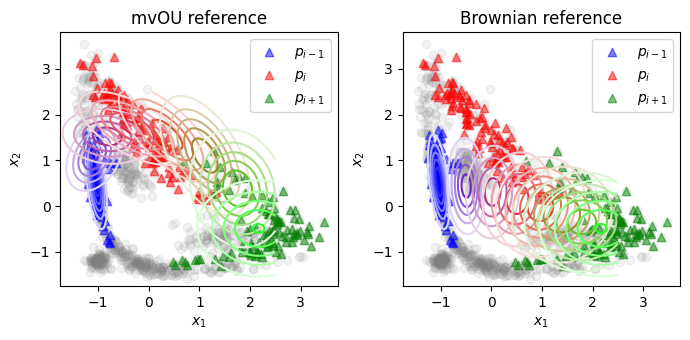

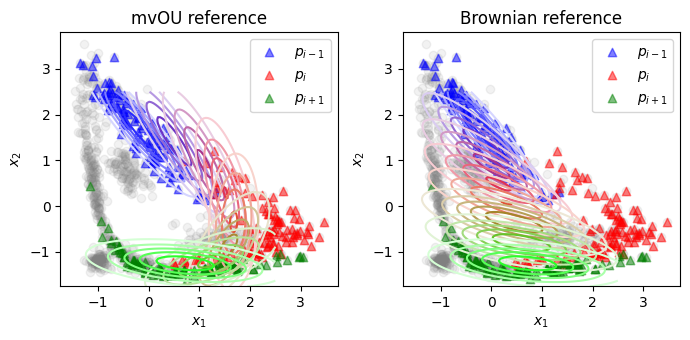

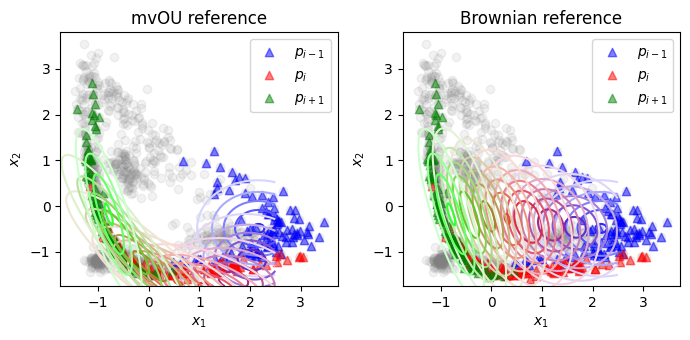

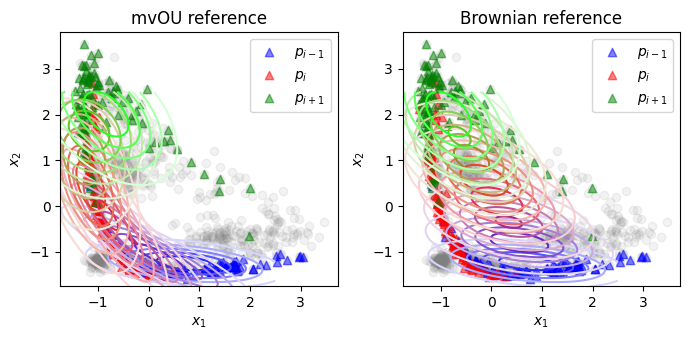

In [12]:
import copy
importlib.reload(fm)
k=0 # dimension to show 
offset = 2
t = torch.linspace(0, 1, 8)
for j in range(T-2):
    plt.figure(figsize = (7, 3.5))
    plt.subplot(1, 2, 1)
    _otfm = copy.deepcopy(otfm)
    _otfm.A *= offset
    _otfm.sigma *= offset**0.5
    gsb = fm.GaussianOUSB(_otfm.bm, _otfm)
    mean0, mean1 = means[j], means[j+offset]
    var0, var1 = covs[j], covs[j+offset]
    sb_means, sb_vars, S_t, d_sb_means = gsb.evaluate(t, mean0, mean1, var0, var1)
    for i in range(len(t)):
        cm = get_cmap(matplotlib.cm.brg(t[i].item()))
        plot_bivariate(sb_means[i].flatten()[k:k+2], sb_vars[i].reshape(d, d)[k:k+2, :][:, k:k+2], cm = cm)
    idx = (data["t_idx"] == j); plt.scatter(data['x'][idx, k], data['x'][idx, k+1], alpha = 0.5, marker = "^", color = 'blue', label = "$p_{i-1}$", rasterized = True)
    idx = (data["t_idx"] == j+offset//2); plt.scatter(data['x'][idx, k], data['x'][idx, k+1], alpha = 0.5, marker = "^", color = 'red', label = "$p_{i}$", rasterized = True)
    idx = (data["t_idx"] == j+offset); plt.scatter(data['x'][idx, k], data['x'][idx, k+1], alpha = 0.5, marker = "^", color = 'green', label = "$p_{i+1}$", rasterized = True)
    plt.scatter(data['x'][:, k], data['x'][:, k+1], alpha = 0.1, marker = "o", color = 'grey', zorder = -100, rasterized = True)
    plt.legend(); plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
    plt.title("mvOU reference")
    plt.subplot(1, 2, 2)
    _otfm = copy.deepcopy(otfm)
    _otfm.A *= 0
    _otfm.sigma *= 2**0.5
    gsb = fm.GaussianOUSB(_otfm.bm, _otfm)
    mean0, mean1 = means[j], means[j+offset]
    var0, var1 = covs[j], covs[j+offset]
    sb_means, sb_vars, S_t, d_sb_means = gsb.evaluate(t, mean0, mean1, var0, var1)
    for i in range(len(t)):
        cm = get_cmap(matplotlib.cm.brg(t[i].item()))
        plot_bivariate(sb_means[i].flatten()[k:k+2], sb_vars[i].reshape(d, d)[k:k+2, :][:, k:k+2], cm = cm)
    idx = (data["t_idx"] == j); plt.scatter(data['x'][idx, k], data['x'][idx, k+1], alpha = 0.5, marker = "^", color = 'blue', label = "$p_{i-1}$", rasterized = True)
    idx = (data["t_idx"] == j+offset//2); plt.scatter(data['x'][idx, k], data['x'][idx, k+1], alpha = 0.5, marker = "^", color = 'red', label = "$p_{i}$", rasterized = True)
    idx = (data["t_idx"] == j+offset); plt.scatter(data['x'][idx, k], data['x'][idx, k+1], alpha = 0.5, marker = "^", color = 'green', label = "$p_{i+1}$", rasterized = True)
    plt.scatter(data['x'][:, k], data['x'][:, k+1], alpha = 0.1, marker = "o", color = 'grey', zorder = -100, rasterized = True)
    plt.legend(); plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
    plt.title("Brownian reference")
    plt.tight_layout()
    plt.savefig(f"../../figures/repressilator_OU_interpolation_{j}.pdf", dpi = 300)

/data/gpfs/projects/punim0638/stephenz/envs/lfm/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/data/gpfs/projects/punim0638/stephenz/envs/lfm/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  retu

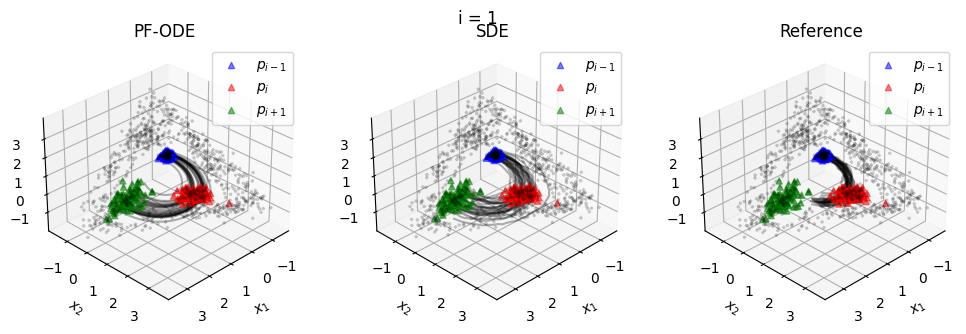

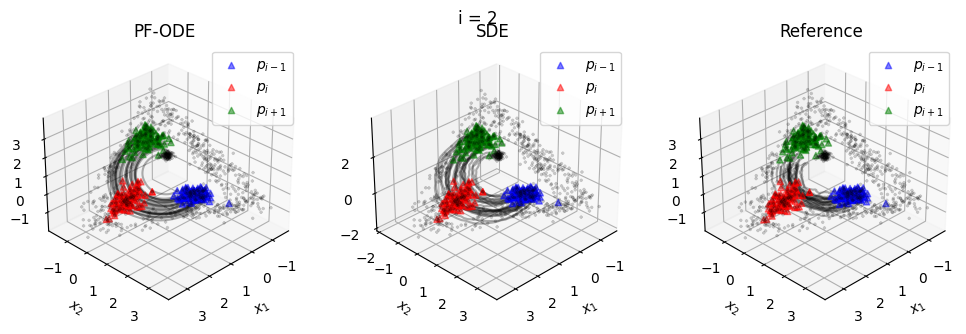

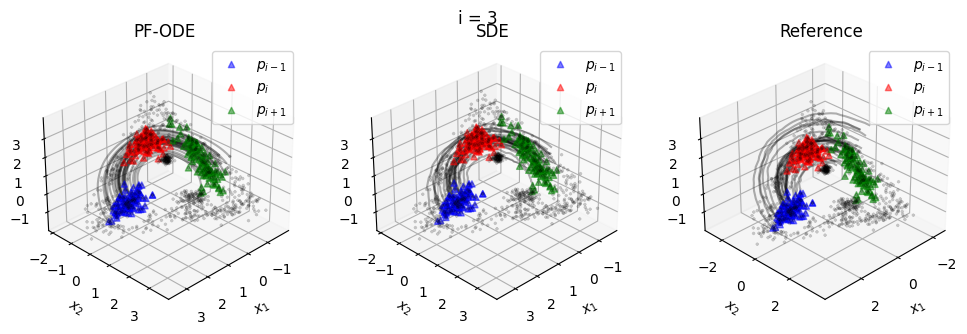

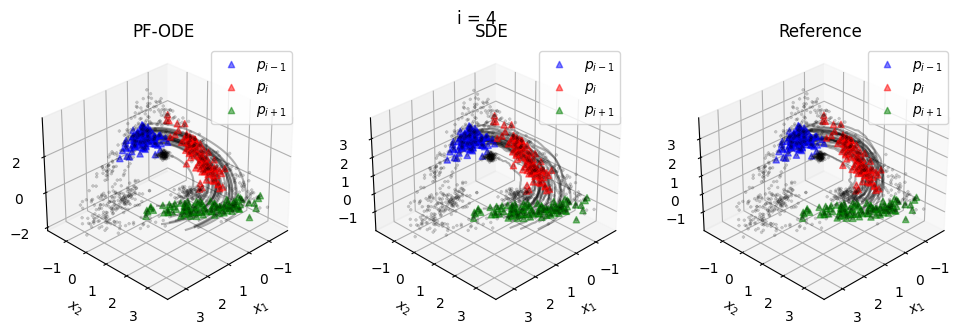

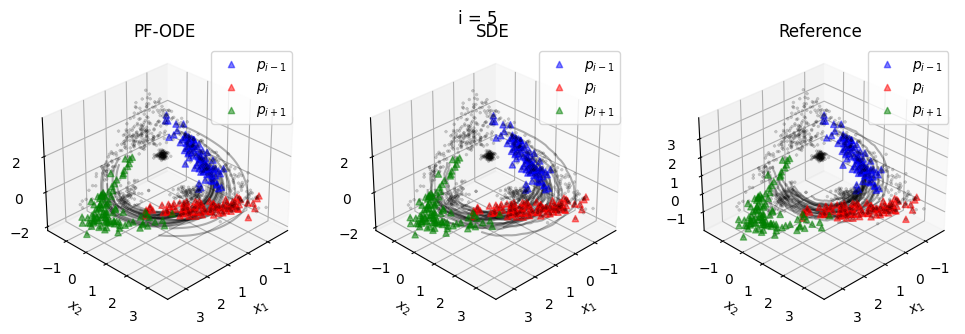

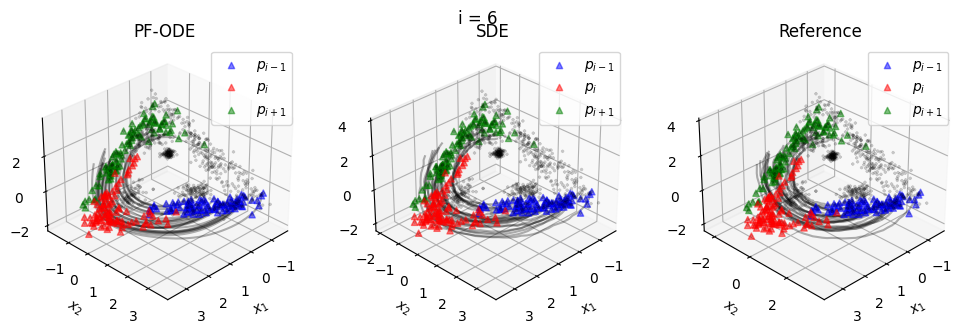

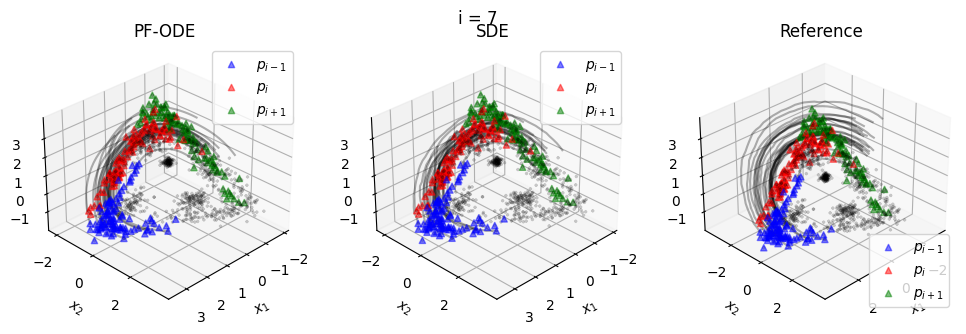

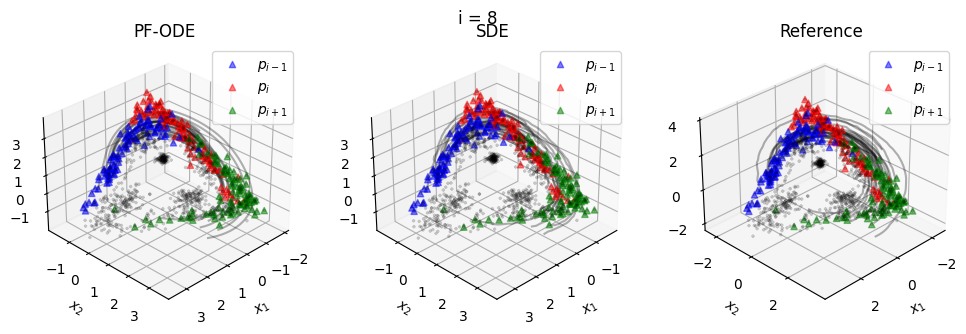

In [13]:
import torchsde
k=0 # dimension to show 
offset = 2
t = torch.linspace(0, 1, 8)

sigma = 0.1
sde = fm.SDE(lambda t, x: v_model(t, x) + sigma**2 / 2 * s_model(t, x), sigma)
ou_sde = OrnsteinUhlenbeck(A = ref_params['A'], sigma = Repressilator().sigma)

for j in range(T-2):
    fig = plt.figure(figsize = (12, 3.5))
    _ts = torch.linspace(ts[j], ts[j+2], 50)
    ax = fig.add_subplot(131, projection='3d')
    ax.view_init(elev=30, azim=45, roll=0)
    ax.scatter(data['x'][..., 0], data['x'][..., 1], data['x'][..., 2], c = 'k', alpha = 0.2, s = 2.5, marker = 'x', rasterized = True)
    idx = (data["t_idx"] == j); ax.scatter(data['x'][idx, 0], data['x'][idx, 1], data['x'][idx, 2], alpha = 0.5, marker = "^", color = 'blue', label = "$p_{i-1}$", rasterized = True)
    idx = (data["t_idx"] == j+offset//2); ax.scatter(data['x'][idx, 0], data['x'][idx, 1], data['x'][idx, 2], alpha = 0.5, marker = "^", color = 'red', label = "$p_{i}$", rasterized = True)
    idx = (data["t_idx"] == j+offset); ax.scatter(data['x'][idx, 0], data['x'][idx, 1], data['x'][idx, 2], alpha = 0.5, marker = "^", color = 'green', label = "$p_{i+1}$", rasterized = True)
    _xs = odeint(v_model, data['x'][data["t_idx"] == j], _ts).detach()
    for l in range(25):
        ax.plot(_xs[:, l, 0], _xs[:, l, 1], _xs[:, l, 2], alpha = 0.3, color = 'k')
    plt.title("PF-ODE")
    plt.legend(); plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
    ax = fig.add_subplot(132, projection='3d')
    ax.view_init(elev=30, azim=45, roll=0)
    ax.scatter(data['x'][..., 0], data['x'][..., 1], data['x'][..., 2], c = 'k', alpha = 0.2, s = 2.5, marker = 'x', rasterized = True)
    idx = (data["t_idx"] == j); ax.scatter(data['x'][idx, 0], data['x'][idx, 1], data['x'][idx, 2], alpha = 0.5, marker = "^", color = 'blue', label = "$p_{i-1}$", rasterized = True)
    idx = (data["t_idx"] == j+offset//2); ax.scatter(data['x'][idx, 0], data['x'][idx, 1], data['x'][idx, 2], alpha = 0.5, marker = "^", color = 'red', label = "$p_{i}$", rasterized = True)
    idx = (data["t_idx"] == j+offset); ax.scatter(data['x'][idx, 0], data['x'][idx, 1], data['x'][idx, 2], alpha = 0.5, marker = "^", color = 'green', label = "$p_{i+1}$", rasterized = True)
    _xs = torchsde.sdeint(sde, data['x'][data["t_idx"] == j], _ts, dt = 1e-2).detach()
    for l in range(25):
        ax.plot(_xs[:, l, 0], _xs[:, l, 1], _xs[:, l, 2], alpha = 0.3, color = 'k')
    plt.title("SDE")
    plt.legend(); plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
    plt.legend(); plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
    ax = fig.add_subplot(133, projection='3d')
    ax.view_init(elev=30, azim=45, roll=0)
    ax.scatter(data['x'][..., 0], data['x'][..., 1], data['x'][..., 2], c = 'k', alpha = 0.2, s = 2.5, marker = 'x', rasterized = True)
    idx = (data["t_idx"] == j); ax.scatter(data['x'][idx, 0], data['x'][idx, 1], data['x'][idx, 2], alpha = 0.5, marker = "^", color = 'blue', label = "$p_{i-1}$", rasterized = True)
    idx = (data["t_idx"] == j+offset//2); ax.scatter(data['x'][idx, 0], data['x'][idx, 1], data['x'][idx, 2], alpha = 0.5, marker = "^", color = 'red', label = "$p_{i}$", rasterized = True)
    idx = (data["t_idx"] == j+offset); ax.scatter(data['x'][idx, 0], data['x'][idx, 1], data['x'][idx, 2], alpha = 0.5, marker = "^", color = 'green', label = "$p_{i+1}$", rasterized = True)
    _xs = torchsde.sdeint(ou_sde, data['x'][data["t_idx"] == j], _ts, dt = 1e-2).detach()
    for l in range(25):
        ax.plot(_xs[:, l, 0], _xs[:, l, 1], _xs[:, l, 2], alpha = 0.3, color = 'k')
    plt.title("Reference")
    plt.legend(); plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
    plt.legend(); plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
    plt.suptitle(f"i = {j+1}")

In [14]:
# Check vector field reconstruction 
v_gt = Repressilator().f(_, torch.tensor(scaler_op.inverse_transform(data['x'])))

tensor(0.1059)
tensor(0.0483)


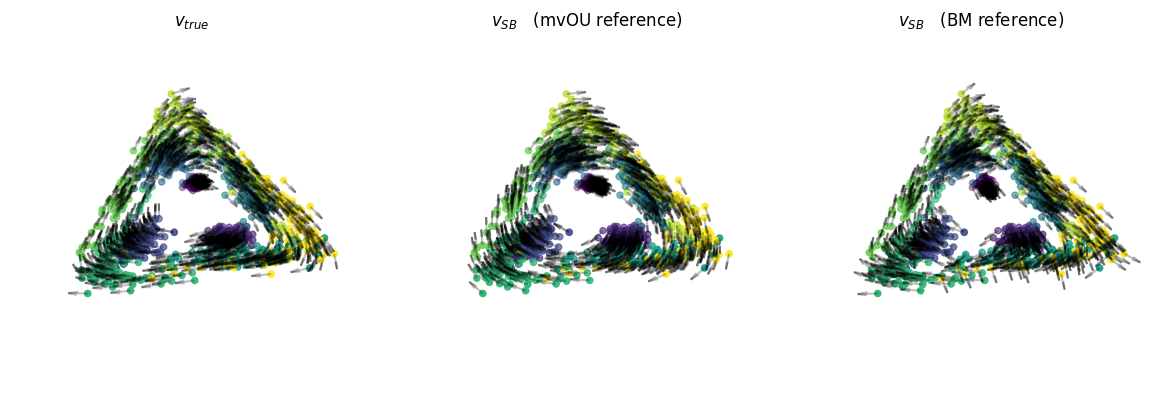

In [15]:
import utils
fig = plt.figure(figsize = (12, 4))
ax = fig.add_subplot(131, projection='3d')
ax.view_init(elev=30, azim=45, roll=0)
plt.title("$v_{true}$")
ax.scatter(data['x'][..., 0], data['x'][..., 1], data['x'][..., 2], c = data['t_idx'], rasterized = True)
ax.quiver(data['x'][..., 0], data['x'][..., 1], data['x'][..., 2], v_gt[..., 0], v_gt[..., 1], v_gt[..., 2], normalize = True, length = 0.5, color = 'k', alpha = 0.25, arrow_length_ratio=0.5, rasterized = True)
plt.axis('off')

ax = fig.add_subplot(133, projection='3d')
it = 0
s_model.load_state_dict(torch.load(f"weights/otfm_score_iter_{it}_{suffix}.pt")); v_model.load_state_dict(torch.load(f"weights/otfm_flow_iter_{it}_{suffix}.pt"))
sde = fm.SDE(lambda t, x: v_model(t, x) + data['sigma']**2 / 2 * s_model(t, x), data['sigma'])
with torch.no_grad():
    v = torch.vstack([sde.f(torch.scalar_tensor(t), data['x'][data['t_idx'] == i, ...]) for i, t in enumerate(ts)])
ax.view_init(elev=30, azim=45, roll=0)
plt.title("$v_{SB}$   (BM reference)")
ax.scatter(data['x'][..., 0], data['x'][..., 1], data['x'][..., 2], c = data['t_idx'], rasterized = True)
ax.quiver(data['x'][..., 0], data['x'][..., 1], data['x'][..., 2], v[..., 0], v[..., 1], v[..., 2], normalize = True, length = 0.5, color = 'k', alpha = 0.25, arrow_length_ratio=0.5, rasterized = True)
plt.axis('off')

print(utils.cos_dist(v_gt.float(), v).mean())

ax = fig.add_subplot(132, projection='3d')
it = 4
s_model.load_state_dict(torch.load(f"weights/otfm_score_iter_{it}_{suffix}.pt")); v_model.load_state_dict(torch.load(f"weights/otfm_flow_iter_{it}_{suffix}.pt"))
sde = fm.SDE(lambda t, x: v_model(t, x) + data['sigma']**2 / 2 * s_model(t, x), data['sigma'])
with torch.no_grad():
    v = torch.vstack([sde.f(torch.scalar_tensor(t), data['x'][data['t_idx'] == i, ...]) for i, t in enumerate(ts)])
ax.view_init(elev=30, azim=45, roll=0)
plt.title("$v_{SB}$   (mvOU reference)")
ax.scatter(data['x'][..., 0], data['x'][..., 1], data['x'][..., 2], c = data['t_idx'], rasterized = True)
ax.quiver(data['x'][..., 0], data['x'][..., 1], data['x'][..., 2], v[..., 0], v[..., 1], v[..., 2], normalize = True, length = 0.5, color = 'k', alpha = 0.25, arrow_length_ratio=0.5, rasterized = True)
plt.axis('off')
print(utils.cos_dist(v_gt.float(), v).mean())

plt.tight_layout()

plt.savefig("../../figures/repressilator_3dplot_vfs.pdf")

In [16]:
with torch.no_grad():
    v = torch.vstack([ou_sde.f(torch.scalar_tensor(t), data['x'][data['t_idx'] == i, ...]) for i, t in enumerate(ts)])
print(utils.cos_dist(v_gt.float(), v).mean())

tensor(0.0600)


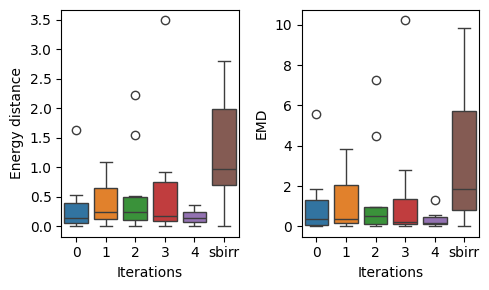

In [17]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
suffix = "leaveout_-1_seed_5"
df = pd.read_csv(f"evals/marginal_validation_{suffix}.csv", index_col = 0).iloc[:, 1:]
plt.figure(figsize = (5, 3))
plt.subplot(1, 2, 1)
sb.boxplot(df[df.index == "energy"]); plt.xlabel("Iterations"); plt.ylabel("Energy distance")
plt.subplot(1, 2, 2)
sb.boxplot(df[df.index == "emd"]); plt.xlabel("Iterations"); plt.ylabel("EMD")
plt.tight_layout()

In [62]:
import glob
_dfs = []
for s in ["_sbirr_OU", "_sbirr_general"]:
    dfs = []
    for i in range(1, 9):
        df = pd.concat([pd.read_csv(x).rename( columns={'Unnamed: 0':'metric', 'Unnamed: 1' : 't'}) for x in glob.glob(f"evals/marginal_adjacent_validation{s}_leaveout_{i}*.csv")])
        df = df.melt(id_vars = ['metric', 't'], value_vars = df.columns[2:])
        dfs.append(df[df.t == i])
    dfs = pd.concat(dfs)
    dfs.rename(columns = {'variable' : 'iteration', 'value' : 'error'}, inplace = True)
    _dfs.append(dfs)
_dfs[0]=_dfs[0].replace({'iteration' : {'sbirr' : 'sbirr_OU'}})
_dfs[1]=_dfs[1].replace({'iteration' : {'sbirr' : 'sbirr_general'}})
dfs = pd.concat([_dfs[0], _dfs[1].loc[_dfs[1].iteration.str.contains('sbirr'), :]], axis = 0)

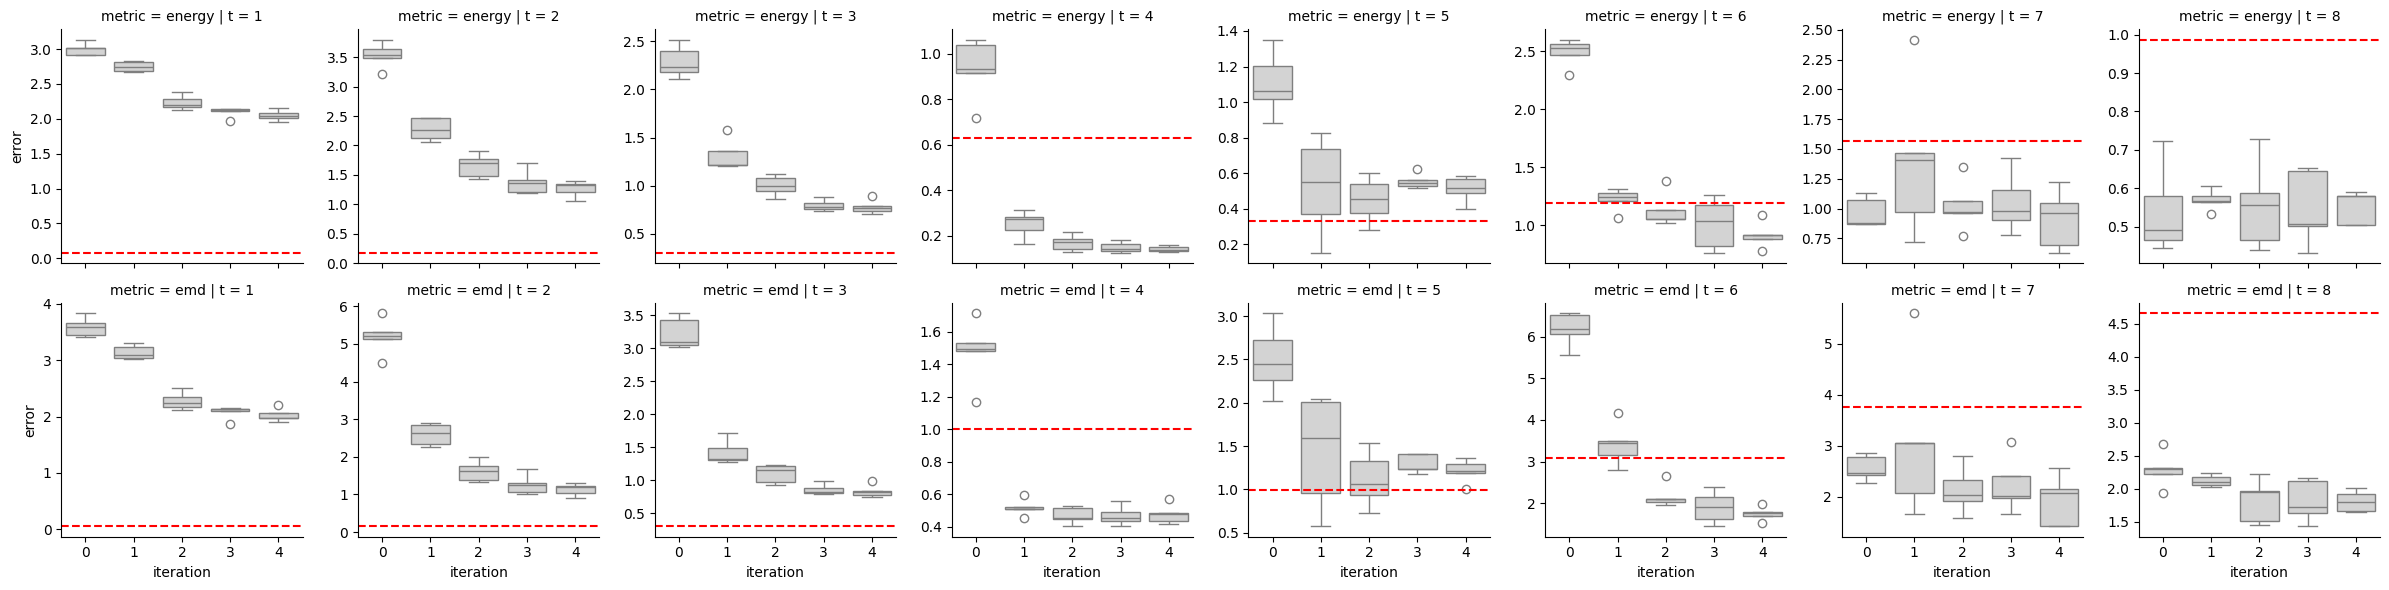

In [63]:
g = sb.FacetGrid(dfs, col="t",  row="metric", sharey = False)
g.map(sb.boxplot, "iteration", "error", order = [0,1,2,3,4], color = "lightgrey")

df_gt = pd.concat([pd.read_csv(x).rename( columns={'Unnamed: 0':'metric', 'Unnamed: 1' : 't'}) for x in glob.glob(f"evals/marginal_adjacent_validation{s}_leaveout_-1_seed_*_gtref.csv")])
df_gt = df_gt.loc[df_gt.t.isin(range(0, 9)), :]
df_gt = df_gt.melt(id_vars = ['metric', 't'], value_vars = df_gt.columns[2:])
df_gt.rename(columns = {'variable' : 'iteration', 'value' : 'error'}, inplace = True)
for row, row_name in enumerate(g.row_names):
    for col, col_name in enumerate(g.col_names):
        ax = g.axes[row, col]
        t = df_gt.loc[(df_gt.metric == row_name) & (df_gt.t == col_name)].error.mean()
        ax.axhline(t, color='red', ls='--')

In [64]:
import numpy as np
_df1_mean = dfs.groupby(['metric' , 't', 'iteration'])[['error']].mean().unstack()
_df1_std = dfs.groupby(['metric' ,'t', 'iteration'])[['error']].std().unstack()
_df1_mean_str = _df1_mean.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
_df1_std_str = _df1_std.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
_df1_str = pd.DataFrame({_df1_mean_str.columns[i] : _df1_mean_str.iloc[:, i].str.cat(_df1_std_str.iloc[:, i], sep = " $\\pm$ ") for i in range(_df1_mean_str.shape[1])})
_df1_str.columns = _df1_mean.columns
for i, j in enumerate(np.argmin(_df1_mean.values, 1)):
    _df1_str.iloc[i, j] = "\\textbf{" + _df1_str.iloc[i, j] + "}"

/tmp/ipykernel_236920/1875060916.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  _df1_mean_str = _df1_mean.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_236920/1875060916.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  _df1_std_str = _df1_std.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)


In [65]:
_df1_str

error                                             \
iteration                0                1                         2   
metric t                                                                
emd    1   3.59 $\pm$ 0.17  3.14 $\pm$ 0.12           2.28 $\pm$ 0.15   
       2   5.20 $\pm$ 0.47  2.59 $\pm$ 0.29           1.62 $\pm$ 0.28   
       3   3.23 $\pm$ 0.24  1.42 $\pm$ 0.18           1.10 $\pm$ 0.14   
       4   1.48 $\pm$ 0.20  0.52 $\pm$ 0.05           0.47 $\pm$ 0.05   
       5   2.50 $\pm$ 0.40  1.43 $\pm$ 0.65  \textbf{1.12 $\pm$ 0.32}   
       6   6.18 $\pm$ 0.41  3.42 $\pm$ 0.50           2.18 $\pm$ 0.28   
       7   2.56 $\pm$ 0.25  3.09 $\pm$ 1.53           2.13 $\pm$ 0.46   
       8   2.29 $\pm$ 0.26  2.12 $\pm$ 0.09           1.82 $\pm$ 0.33   
energy 1   3.00 $\pm$ 0.09  2.75 $\pm$ 0.07           2.24 $\pm$ 0.10   
       2   3.53 $\pm$ 0.21  2.27 $\pm$ 0.19           1.66 $\pm$ 0.20   
       3   2.29 $\pm$ 0.17  1.31 $\pm$ 0.16           1.00 $\pm$ 0.10   
       4   0.93 $\pm$ 0.14  0.25 $\pm$ 0.06           0.17 $\pm$ 0.04   
       5   1.10 $\pm$ 0.18  0.53 $\pm$ 0.27  \textbf{0.45 $\pm$ 0.13}   
       6   2.49 $\pm$ 0.12  1.22 $\pm$ 0.10           1.13 $\pm$ 0.15   
       7   0.97 $\pm$ 0.13  1.39 $\pm$ 0.65           1.02 $\pm$ 0.21   
       8   0.54 $\pm$ 0.11  0.57 $\pm$ 0.03           0.56 $\pm$ 0.11   

                                                               \
iteration                         3                         4   
metric t                                                        
emd    1            2.08 $\pm$ 0.11  \textbf{2.02 $\pm$ 0.11}   
       2            1.27 $\pm$ 0.25  \textbf{1.13 $\pm$ 0.16}   
       3            0.86 $\pm$ 0.08  \textbf{0.83 $\pm$ 0.10}   
       4   \textbf{0.47 $\pm$ 0.06}           0.48 $\pm$ 0.06   
       5            1.29 $\pm$ 0.11           1.21 $\pm$ 0.13   
       6            1.91 $\pm$ 0.38  \textbf{1.75 $\pm$ 0.17}   
       7            2.23 $\pm$ 0.55           1.93 $\pm$ 0.50   
       8            1.81 $\pm$ 0.31  \textbf{1.81 $\pm$ 0.16}   
energy 1            2.10 $\pm$ 0.07  \textbf{2.05 $\pm$ 0.08}   
       2            1.38 $\pm$ 0.21  \textbf{1.26 $\pm$ 0.13}   
       3            0.80 $\pm$ 0.06  \textbf{0.78 $\pm$ 0.07}   
       4            0.15 $\pm$ 0.02  \textbf{0.14 $\pm$ 0.01}   
       5            0.55 $\pm$ 0.04           0.51 $\pm$ 0.07   
       6            1.01 $\pm$ 0.22           0.91 $\pm$ 0.11   
       7            1.05 $\pm$ 0.25           0.91 $\pm$ 0.25   
       8            0.55 $\pm$ 0.10           0.55 $\pm$ 0.04   

                                                      
iteration         sbirr_OU             sbirr_general  
metric t                                              
emd    1   2.24 $\pm$ 0.28           2.71 $\pm$ 0.41  
       2   3.13 $\pm$ 0.62           2.29 $\pm$ 0.92  
       3   2.67 $\pm$ 0.85           1.39 $\pm$ 0.55  
       4   1.38 $\pm$ 0.46           0.94 $\pm$ 0.28  
       5   1.63 $\pm$ 0.17           1.40 $\pm$ 0.71  
       6   2.40 $\pm$ 0.32           1.96 $\pm$ 1.41  
       7   1.45 $\pm$ 0.20  \textbf{0.51 $\pm$ 0.13}  
       8   1.93 $\pm$ 0.61           2.14 $\pm$ 0.40  
energy 1   2.20 $\pm$ 0.18           2.56 $\pm$ 0.26  
       2   2.61 $\pm$ 0.33           2.05 $\pm$ 0.61  
       3   2.10 $\pm$ 0.52           1.25 $\pm$ 0.43  
       4   0.99 $\pm$ 0.38           0.84 $\pm$ 0.25  
       5   0.64 $\pm$ 0.10           0.66 $\pm$ 0.37  
       6   1.43 $\pm$ 0.17  \textbf{0.90 $\pm$ 0.64}  
       7   0.65 $\pm$ 0.09  \textbf{0.17 $\pm$ 0.08}  
       8   0.48 $\pm$ 0.08  \textbf{0.36 $\pm$ 0.06}

In [67]:
print(_df1_str.to_latex())

\begin{tabular}{lllllllll}
\toprule
 &  & \multicolumn{7}{r}{error} \\
 & iteration & 0 & 1 & 2 & 3 & 4 & sbirr_OU & sbirr_general \\
metric & t &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{8}{*}{emd} & 1 & 3.59 $\pm$ 0.17 & 3.14 $\pm$ 0.12 & 2.28 $\pm$ 0.15 & 2.08 $\pm$ 0.11 & \textbf{2.02 $\pm$ 0.11} & 2.24 $\pm$ 0.28 & 2.71 $\pm$ 0.41 \\
 & 2 & 5.20 $\pm$ 0.47 & 2.59 $\pm$ 0.29 & 1.62 $\pm$ 0.28 & 1.27 $\pm$ 0.25 & \textbf{1.13 $\pm$ 0.16} & 3.13 $\pm$ 0.62 & 2.29 $\pm$ 0.92 \\
 & 3 & 3.23 $\pm$ 0.24 & 1.42 $\pm$ 0.18 & 1.10 $\pm$ 0.14 & 0.86 $\pm$ 0.08 & \textbf{0.83 $\pm$ 0.10} & 2.67 $\pm$ 0.85 & 1.39 $\pm$ 0.55 \\
 & 4 & 1.48 $\pm$ 0.20 & 0.52 $\pm$ 0.05 & 0.47 $\pm$ 0.05 & \textbf{0.47 $\pm$ 0.06} & 0.48 $\pm$ 0.06 & 1.38 $\pm$ 0.46 & 0.94 $\pm$ 0.28 \\
 & 5 & 2.50 $\pm$ 0.40 & 1.43 $\pm$ 0.65 & \textbf{1.12 $\pm$ 0.32} & 1.29 $\pm$ 0.11 & 1.21 $\pm$ 0.13 & 1.63 $\pm$ 0.17 & 1.40 $\pm$ 0.71 \\
 & 6 & 6.18 $\pm$ 0.41 & 3.42 $\pm$ 0.50 & 2.18 $\pm$ 0.28 & 1.91 $\pm$ 0.38 & \text

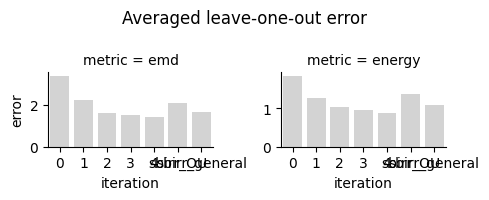

In [82]:
_df = pd.DataFrame(dfs.groupby(['metric', 'iteration'])['error'].mean().reset_index())
g=sb.FacetGrid(_df, col = "metric", sharey = False, height = 2, aspect = 1.25)
g.map(sb.barplot, "iteration", "error", order = [0,1,2,3,4, 'sbirr_OU', 'sbirr_general'], color = "lightgrey")
plt.suptitle("Averaged leave-one-out error")
plt.tight_layout()
plt.savefig("../../figures/repressilator_leave_one_out_avg.pdf")

In [72]:
_df1_mean = dfs.groupby(['metric' ,'iteration'])[['error']].mean().unstack()
_df1_std = dfs.groupby(['metric' ,'iteration'])[['error']].std().unstack()
_df1_mean_str = _df1_mean.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
_df1_std_str = _df1_std.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
_df1_str = pd.DataFrame({_df1_mean_str.columns[i] : _df1_mean_str.iloc[:, i].str.cat(_df1_std_str.iloc[:, i], sep = " $\\pm$ ") for i in range(_df1_mean_str.shape[1])})
_df1_str.columns = _df1_mean.columns
for i, j in enumerate(np.argmin(_df1_mean.values, 1)):
    _df1_str.iloc[i, j] = "\\textbf{" + _df1_str.iloc[i, j] + "}"

/tmp/ipykernel_236920/3722398122.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  _df1_mean_str = _df1_mean.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
/tmp/ipykernel_236920/3722398122.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  _df1_std_str = _df1_std.applymap(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)


In [73]:
print(_df1_str.to_latex())

\begin{tabular}{llllllll}
\toprule
 & \multicolumn{7}{r}{error} \\
iteration & 0 & 1 & 2 & 3 & 4 & sbirr_OU & sbirr_general \\
metric &  &  &  &  &  &  &  \\
\midrule
emd & 3.38 $\pm$ 1.52 & 2.22 $\pm$ 1.12 & 1.59 $\pm$ 0.66 & 1.49 $\pm$ 0.64 & \textbf{1.40 $\pm$ 0.57} & 2.10 $\pm$ 0.74 & 1.67 $\pm$ 0.95 \\
energy & 1.86 $\pm$ 1.06 & 1.29 $\pm$ 0.86 & 1.03 $\pm$ 0.65 & 0.95 $\pm$ 0.58 & \textbf{0.89 $\pm$ 0.55} & 1.39 $\pm$ 0.82 & 1.10 $\pm$ 0.86 \\
\bottomrule
\end{tabular}



In [74]:
_df1_str

error                                                     \
iteration                0                1                2                3   
metric                                                                          
emd        3.38 $\pm$ 1.52  2.22 $\pm$ 1.12  1.59 $\pm$ 0.66  1.49 $\pm$ 0.64   
energy     1.86 $\pm$ 1.06  1.29 $\pm$ 0.86  1.03 $\pm$ 0.65  0.95 $\pm$ 0.58   

                                                                       
iteration                         4         sbirr_OU    sbirr_general  
metric                                                                 
emd        \textbf{1.40 $\pm$ 0.57}  2.10 $\pm$ 0.74  1.67 $\pm$ 0.95  
energy     \textbf{0.89 $\pm$ 0.55}  1.39 $\pm$ 0.82  1.10 $\pm$ 0.86